In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model,load_model

In [5]:
name_lst = list(map(lambda x: x[7:-4], glob.glob(r"./data/*_onehot.csv")))
print(name_lst)
data = pd.read_csv('./data/SamsungE_onehot.csv', index_col = 0)
data.head()

['LGE_onehot', 'NAVER_onehot', 'SamsungBL_onehot', 'SamsungEU_onehot', 'SamsungE_onehot', 'SKH_onehot']


,weekdate,SamsungE_RU,SamsungE_U,SamsungE_UC,SamsungE_D,SamsungE_RD,SamsungE_end,SamsungE_start,SamsungE_high,SamsungE_low,SamsungE_abount
date,,,,,,,,,,,
17/01/02,0,1805000,0.0,0.0,1.0,0.0,0.0,1799000,1812000,1794000,93012
17/01/03,1,1824000,0.0,1.0,0.0,0.0,0.0,1814000,1831000,1801000,147153
17/01/04,2,1808000,0.0,0.0,0.5,0.5,0.0,1825000,1826000,1805000,159435
17/01/05,3,1778000,0.0,0.0,0.0,1.0,0.0,1803000,1803000,1777000,219349
17/01/06,4,1810000,0.0,1.0,0.0,0.0,0.0,1809000,1822000,1802000,177619


In [8]:
datas = [pd.read_csv(path, index_col = 0) for path in glob.glob(r"./data/*_onehot.csv")]
data = datas[0]

for d in datas[1:]:
    data = pd.merge(data,d,left_index=True, right_index=True, on = 'weekdate')

data.head()

,weekdate,LGE_RU,LGE_U,LGE_UC,LGE_D,LGE_RD,LGE_end,LGE_start,LGE_high,LGE_low,...,SKH_RU,SKH_U,SKH_UC,SKH_D,SKH_RD,SKH_end,SKH_start,SKH_high,SKH_low,SKH_abount
date,,,,,,,,,,,,,,,,,,,,,
17/01/02,0,51600,0.0,0.0,1.0,0.0,0.0,51800,52300,51600,...,45800,0.0,1.0,0.0,0.0,0.0,44750,46000,44600,1547681
17/01/03,1,54300,1.0,0.0,0.0,0.0,0.0,51800,54400,51800,...,47250,0.5,0.5,0.0,0.0,0.0,46200,47300,46200,2655477
17/01/04,2,53800,0.0,0.0,0.5,0.5,0.0,54200,54500,53100,...,46500,0.0,0.0,0.0,1.0,0.0,47000,47150,46200,2722599
17/01/05,3,53600,0.0,0.0,1.0,0.0,0.0,54000,55700,53400,...,46950,0.0,0.5,0.5,0.0,0.0,47000,47500,46850,2377163
17/01/06,4,52600,0.0,0.0,0.0,1.0,0.0,53800,54000,52400,...,48000,0.0,1.0,0.0,0.0,0.0,47700,48450,47600,3166843


In [9]:
def moving_window(data,sequence_num,step):
    X_train = []
    for i in range(0,len(data)-sequence_num,step):
        X_train.append(data[i:i+sequence_num])
    
    X_train = np.array(X_train)
    return X_train

train = moving_window(data,30,1)

def normalization(train):
    global name_lst
    for t in train:
        t[:,0] = t[:,0]/4
        a_num = 10
        for i in range(len(name_lst)):
            p_max = t[:,8+ i*a_num].max(axis = 0)
            p_min = t[:,9+ i*a_num].min(axis = 0)
            a_max = t[:,10+ i*a_num].max(axis = 0)
            t[:,1+i*a_num] = (t[:,1+i*a_num] - p_min)/(p_max-p_min)
            t[:,7+i*a_num] = (t[:,7+i*a_num] - p_min)/(p_max-p_min)
            t[:,8+i*a_num] = (t[:,8+i*a_num] - p_min)/(p_max-p_min)
            t[:,9+i*a_num] = (t[:,9+i*a_num] - p_min)/(p_max-p_min)
            t[:,10+i*a_num] = t[:,10+i*a_num]/a_max
            
normalization(train)
df = pd.DataFrame(train[0])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.00,0.037037,0.0,0.0,1.0,0.0,0.0,0.055556,0.101852,0.037037,...,0.116505,0.0,1.0,0.0,0.0,0.0,0.014563,0.135922,0.000000,0.169686
1,0.25,0.287037,1.0,0.0,0.0,0.0,0.0,0.055556,0.296296,0.055556,...,0.257282,0.5,0.5,0.0,0.0,0.0,0.155340,0.262136,0.155340,0.291143
2,0.50,0.240741,0.0,0.0,0.5,0.5,0.0,0.277778,0.305556,0.175926,...,0.184466,0.0,0.0,0.0,1.0,0.0,0.233010,0.247573,0.155340,0.298502
3,0.75,0.222222,0.0,0.0,1.0,0.0,0.0,0.259259,0.416667,0.203704,...,0.228155,0.0,0.5,0.5,0.0,0.0,0.233010,0.281553,0.218447,0.260629
4,1.00,0.129630,0.0,0.0,0.0,1.0,0.0,0.240741,0.259259,0.111111,...,0.330097,0.0,1.0,0.0,0.0,0.0,0.300971,0.373786,0.291262,0.347208


In [10]:
nan_list = list(np.where(np.isnan(train)==True)[0])
train = np.delete(train, nan_list,0)

In [23]:
LReLU = tf.keras.layers.LeakyReLU()

X = Input(shape=[29,61])
H = LSTM(64,activation = LReLU, return_sequences = True)(X)
H = LSTM(32,activation = LReLU, return_sequences = True)(H)
H = LSTM(16,activation = LReLU, return_sequences = True)(H)
H = LSTM(8,activation = LReLU, return_sequences = True)(H)
H = LSTM(5,activation = 'softmax', return_sequences = False)(H)
Y = tf.keras.layers.Reshape((1,5))(H)
model = Model(X, Y)

cross = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="categorical_crossentropy")

adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss=cross)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29, 61)]          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 29, 64)            32256     
_________________________________________________________________
lstm_16 (LSTM)               (None, 29, 32)            12416     
_________________________________________________________________
lstm_17 (LSTM)               (None, 29, 16)            3136      
_________________________________________________________________
lstm_18 (LSTM)               (None, 29, 8)             800       
_________________________________________________________________
lstm_19 (LSTM)               (None, 5)                 280       
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 5)              0   

In [25]:
adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss=cross)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
history = model.fit(train[:,0:29],train[:,29:30,[2,3,4,5,6]],epochs = 500,callbacks=[early_stopping],batch_size = 20,validation_split = 0.05)

Epoch 1/500
57/57 [==============================] - 7s 34ms/step - loss: 1.3749 - val_loss: 1.4316
Epoch 2/500
57/57 [==============================] - 1s 24ms/step - loss: 1.3852 - val_loss: 1.4399
Epoch 3/500
57/57 [==============================] - 1s 24ms/step - loss: 1.3898 - val_loss: 1.4383
Epoch 4/500
57/57 [==============================] - 1s 24ms/step - loss: 1.3940 - val_loss: 1.4371
Epoch 5/500
57/57 [==============================] - 1s 24ms/step - loss: 1.3708 - val_loss: 1.4357
Epoch 6/500
57/57 [==============================] - 1s 24ms/step - loss: 1.3684 - val_loss: 1.4329
Epoch 7/500
57/57 [==============================] - 1s 24ms/step - loss: 1.3901 - val_loss: 1.4300
Epoch 8/500
57/57 [==============================] - 1s 24ms/step - loss: 1.3598 - val_loss: 1.4310
Epoch 9/500
57/57 [==============================] - 1s 24ms/step - loss: 1.3689 - val_loss: 1.4335
Epoch 10/500
57/57 [==============================] - 1s 24ms/step - loss: 1.3777 - val_loss: 1.4516

In [26]:
adam = tf.keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,loss=cross)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30, restore_best_weights = True)

history = model.fit(train[:,0:29],train[:,29:30,[2,3,4,5,6]],epochs = 500,callbacks=[early_stopping], batch_size = 20,validation_split = 0.05)

Epoch 1/500
57/57 [==============================] - 7s 37ms/step - loss: 1.3765 - val_loss: 1.4292
Epoch 2/500
57/57 [==============================] - 2s 27ms/step - loss: 1.3507 - val_loss: 1.4304
Epoch 3/500
57/57 [==============================] - 2s 27ms/step - loss: 1.3491 - val_loss: 1.4295
Epoch 4/500
57/57 [==============================] - 2s 27ms/step - loss: 1.3761 - val_loss: 1.4299
Epoch 5/500
57/57 [==============================] - 2s 27ms/step - loss: 1.3798 - val_loss: 1.4309
Epoch 6/500
57/57 [==============================] - 2s 27ms/step - loss: 1.3593 - val_loss: 1.4319
Epoch 7/500
57/57 [==============================] - 2s 27ms/step - loss: 1.3659 - val_loss: 1.4311
Epoch 8/500
57/57 [==============================] - 2s 27ms/step - loss: 1.3613 - val_loss: 1.4315
Epoch 9/500
57/57 [==============================] - 2s 27ms/step - loss: 1.3557 - val_loss: 1.4318
Epoch 10/500
57/57 [==============================] - 2s 27ms/step - loss: 1.3839 - val_loss: 1.4316

In [27]:
Y = model.predict(train[:,0:29])
np.where(Y>0.5)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [17]:
print(train[:15,29:30,2:7])

[[[0.  1.  0.  0.  0. ]]

 [[0.  0.5 0.5 0.  0. ]]

 [[0.  0.5 0.5 0.  0. ]]

 [[0.  0.  0.  1.  0. ]]

 [[0.  0.5 0.5 0.  0. ]]

 [[0.  0.  1.  0.  0. ]]

 [[0.  1.  0.  0.  0. ]]

 [[0.  0.  1.  0.  0. ]]

 [[0.  0.  0.5 0.5 0. ]]

 [[0.  0.  0.  0.  1. ]]

 [[0.  1.  0.  0.  0. ]]

 [[0.5 0.5 0.  0.  0. ]]

 [[0.  0.5 0.5 0.  0. ]]

 [[0.  0.  0.  0.5 0.5]]

 [[0.5 0.5 0.  0.  0. ]]]


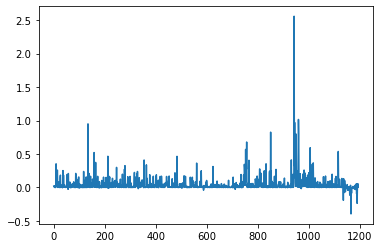

In [12]:
ev = train[:,29:30,2]*Y
plt.plot(ev)
plt.show()

In [13]:
len(np.where(ev > 0)[0])

1029